
# UNHCR Registered Refugees vs. Donor Contributions to the Syrian Refugee Response in Jordan

## Data Sources
### UNHCR Refugee Data
“Situation Syria Regional Refugee Response,” last updated April 30, 2025. [link](https://data.unhcr.org/en/situations/syria/location/36)
* Click the JSON button by "Refugees from Syria by Date" and save the file. That is located at [link]("./data/unhcr.json")

### UN OCHA FTS Data
“Syrian Arab Republic Regional Refugee and Resilience Plan (3RP),” UNOCHA Financial Tracking Service, 2013-2024 [link](https://fts.unocha.org/plans/1168/flows?f%5B0%5D=flowStatus%3Apaid).
* Need to navigate to the funding page for each year from 2013-2024 and click the download button. Those Excel files are located [here]("./data/ocha-fts/")

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import json

## Annual Data for Refugees Residing in Camps

In [2]:
raw_json = json.load(open('./data/unhcr.json','r'))
camp = raw_json['0']['data']['timeseries']
camp_df = pd.DataFrame.from_dict(camp)
camp_df['data_date'] = pd.to_datetime(camp_df['data_date'])
camp_df['year'] = camp_df['data_date'].dt.year
yearly_refugees = camp_df.groupby('year')['individuals'].last().reset_index() # obtain the refugee count at year end
yearly_refugees

,year,individuals
0,2013,127796
1,2014,100014
2,2015,114242
3,2016,136879
4,2017,139500
5,2018,126064
6,2019,123084
7,2020,126832
8,2021,131309
9,2022,134582


## Annual Data for Refugees Residing in Urban Areas

In [3]:
urban = raw_json['1']['data']['timeseries']
urban_df = pd.DataFrame.from_dict(urban)
urban_df['data_date'] = pd.to_datetime(urban_df['data_date'])
urban_df['year'] = urban_df['data_date'].dt.year
urban_yearly_refugees = urban_df.groupby('year')['individuals'].last().reset_index() # obtain the refugee count at year end
urban_yearly_refugees

,year,individuals
0,2012,234642
1,2013,451501
2,2014,525244
3,2015,533583
4,2016,514029
5,2017,516513
6,2018,546011
7,2019,531802
8,2020,535862
9,2021,542288


In [4]:
yearly_refugees = yearly_refugees.merge(urban_yearly_refugees, on='year', suffixes=('_camp', '_urban'))

In [5]:
yearly_refugees['total'] = yearly_refugees['individuals_camp'] + yearly_refugees['individuals_urban']
yearly_refugees

,year,individuals_camp,individuals_urban,total
0,2013,127796,451501,579297
1,2014,100014,525244,625258
2,2015,114242,533583,647825
3,2016,136879,514029,650908
4,2017,139500,516513,656013
5,2018,126064,546011,672075
6,2019,123084,531802,654886
7,2020,126832,535862,662694
8,2021,131309,542288,673597
9,2022,134582,526774,661356


## Load UNOCHA FTS Data

In [6]:
xl_files = []
for file in os.listdir('./data/ocha-fts'):
    xl_files.append(os.fsdecode(file))
xl_files


['fts_2023.xlsx',
 'fts_2013.xlsx',
 'fts_2016.xlsx',
 'fts_2022.xlsx',
 'fts_2014.xlsx',
 'fts_2015.xlsx',
 'fts_2017.xlsx',
 'fts_2019.xlsx',
 'fts_2021.xlsx',
 'fts_2024.xlsx',
 'fts_2020.xlsx',
 'fts_2018.xlsx']

# Filter Contributions
## Boundary
We only care about incoming flows. We are analyzing donor contributions, not internal allocations of the Jordanian government. [See more here](https://fts.unocha.org/glossary/boundary)
> The FTS database records flows of funding, and draws boundaries around (combinations of) flow properties to calculate totals. Examples of common boundaries are a response plan/appeal or a combination of a (donor or affected) country and a year. Drawing a boundary classifies the flows in the database into those crossing the boundary inward (incoming flows), those originating and terminating within the boundary (internal flows), those crossing it outwards (outgoing flows), and a fourth category that is not displayed  - those that are irrelevant to the boundary because they originate and terminate outside of it.

## Funding Status
Given the tumult in the aid landscape, we want to focus on paid contributions. Commitments may or may not be honored. No glossary entry is available but.

In [20]:
contributions_data = {}
for file in xl_files:
    year = file.replace('.xlsx','').split('_')[1] # Extract year from filename
    fts = pd.read_excel(f"./data/ocha-fts/{file}", 'Export data')
    fts.columns = fts.iloc[1] # Columns are located at row 1
    fts = fts.drop(0)
    fts = fts.drop(1)
    fts = fts[fts['Destination country'] == 'Jordan']
    fts = fts[fts['Boundary'] == 'Incoming'] # We only care about incoming contributions
    fts = fts[fts['Funding status'] == 'Paid Contribution']
    total = fts['Amount (US$)'].sum()
    contributions_data[year] = total
contributions_data

{'2023': 246074943,
 '2013': 623679926,
 '2016': 535363004,
 '2022': 349491534,
 '2014': 609241510,
 '2015': 644239946,
 '2017': 588004881,
 '2019': 486998618,
 '2021': 369747627,
 '2024': 318167604,
 '2020': 442956834,
 '2018': 485939325}

## Combine Datasets

In [8]:
# Convert contributions dictionary to dataframe
contributions_df = pd.DataFrame(list(contributions_data.items()), columns=['year', 'contributions'])
contributions_df['year'] = contributions_df['year'].astype(int)
contributions_df['contributions_millions'] = contributions_df['contributions'] / 1000000
contributions_df = contributions_df.sort_values('year')

# Combine datasets
combined_data = pd.merge(yearly_refugees, contributions_df, on='year', how='outer')
combined_data = combined_data.sort_values('year')

# Fill any missing years and sort
min_year = min(combined_data['year'])
max_year = max(combined_data['year'])
all_years = pd.DataFrame({'year': range(min_year, max_year + 1)})
combined_data = pd.merge(all_years, combined_data, on='year', how='left')
combined_data = combined_data.sort_values('year')

# Fill missing values with interpolation for smoother transition
combined_data['individuals'] = combined_data['total'].interpolate(method='cubic')
combined_data['contributions_millions'] = combined_data['contributions_millions'].interpolate(method='cubic')
combined_data

,year,individuals_camp,individuals_urban,total,contributions,contributions_millions,individuals
0,2013,127796,451501,579297,623679926.0,623.679926,579297
1,2014,100014,525244,625258,609241510.0,609.241510,625258
2,2015,114242,533583,647825,644239946.0,644.239946,647825
3,2016,136879,514029,650908,535363004.0,535.363004,650908
4,2017,139500,516513,656013,588004881.0,588.004881,656013
5,2018,126064,546011,672075,485939325.0,485.939325,672075
6,2019,123084,531802,654886,486998618.0,486.998618,654886
7,2020,126832,535862,662694,442956834.0,442.956834,662694
8,2021,131309,542288,673597,369747627.0,369.747627,673597
9,2022,134582,526774,661356,349491534.0,349.491534,661356


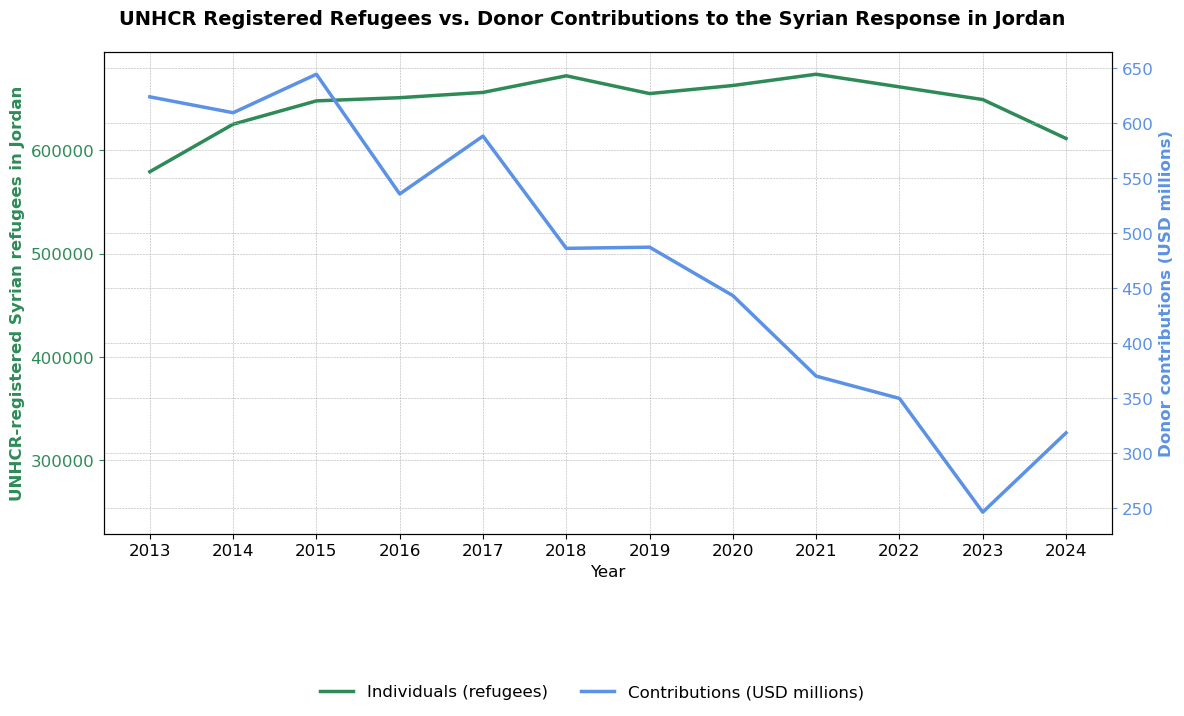

In [9]:
# ─── Colors ─────────────────────────────────────────────────────────────────────
GREEN   = "#2E8B57"   # individuals
UN_BLUE = "#5B92E5"   # contributions

# ─── Data ───────────────────────────────────────────────────────────────────────
plot_df = combined_data.dropna(
    subset=["year", "individuals", "contributions_millions"]
)

# ─── Global style tweaks ────────────────────────────────────────────────────────
plt.rcParams.update(
    {
        "figure.figsize": (12, 6),
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.linewidth": 0.4,
        "font.size": 12,
    }
)

# ─── Figure & Axes ──────────────────────────────────────────────────────────────
fig, ax_ind = plt.subplots()

# Individuals (left y-axis)
line_ind, = ax_ind.plot(
    plot_df["year"],
    plot_df["individuals"],
    color=GREEN,
    linewidth=2.5,
    label="Individuals (refugees)",
)

# Tighten y-limits so fluctuations stand out
ind_min, ind_max = 250000, plot_df["individuals"].max()
margin = 0.05 * (ind_max - ind_min)
ax_ind.set_ylim(ind_min - margin, ind_max + margin)

ax_ind.set_ylabel("UNHCR-registered Syrian refugees in Jordan", color=GREEN, weight="bold")
ax_ind.tick_params(axis="y", colors=GREEN)

# Contributions (right y-axis)
ax_con = ax_ind.twinx()
line_con, = ax_con.plot(
    plot_df["year"],
    plot_df["contributions_millions"],
    color=UN_BLUE,
    linewidth=2.5,
    label="Contributions (USD millions)",
)

ax_con.set_ylabel("Donor contributions (USD millions)", color=UN_BLUE, weight="bold")
ax_con.tick_params(axis="y", colors=UN_BLUE)

# X-axis, title, legend
ax_ind.set_xlabel("Year")
ax_ind.set_xticks(plot_df["year"])

fig.suptitle(
    "UNHCR Registered Refugees vs. Donor Contributions to the Syrian Response in Jordan",
    fontsize=14,
    weight="bold",
)

fig.legend(
    handles=[line_ind, line_con],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.12),
    ncol=2,
    frameon=False,
)

plt.tight_layout()
plt.show()

# ─── Export ────────────────────────────────────────────────────────────────────
fig.savefig("contributions_vs_individuals.png", dpi=300, bbox_inches="tight")


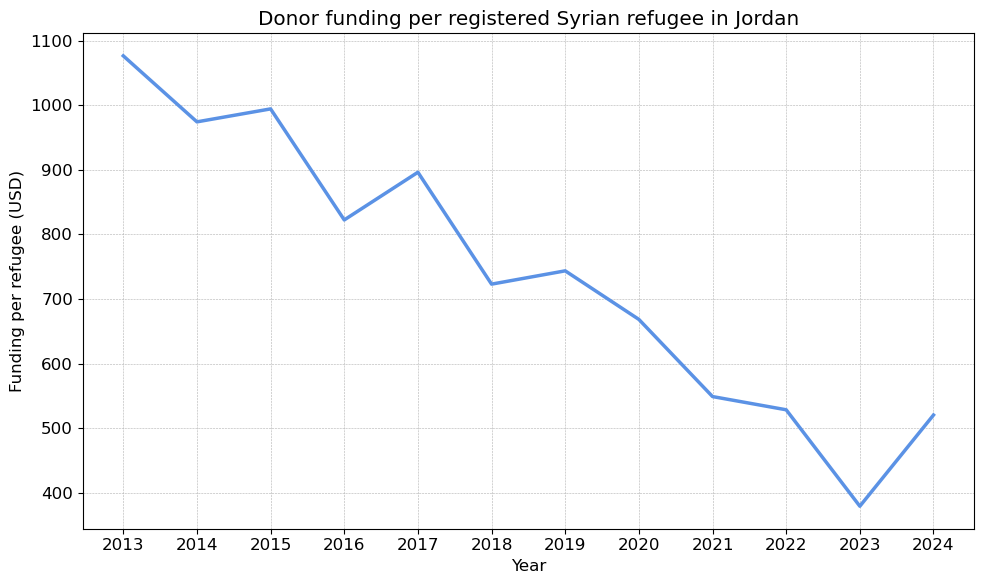

In [10]:
# Prepare data
plot_df = combined_data.dropna(
    subset=["year", "individuals", "contributions_millions"]
).copy()

plot_df["funding_per_refugee_usd"] = (
    plot_df["contributions_millions"] * 1_000_000
) / plot_df["individuals"]

# Plot funding per refugee (USD)
plt.figure(figsize=(10, 6))
plt.plot(
    plot_df["year"],
    plot_df["funding_per_refugee_usd"],
    color="#5B92E5",
    linewidth=2.5,
)

plt.xlabel("Year")
plt.ylabel("Funding per refugee (USD)")
plt.title("Donor funding per registered Syrian refugee in Jordan")
plt.grid(True, linestyle="--", linewidth=0.4)
plt.xticks(plot_df["year"])
plt.tight_layout()
plt.show()
